# Spherical harmonics visualisation

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
from matplotlib.colors import Normalize
from matplotlib.colors import LightSource

from visualization.spherical_harmonics_visualization import plotAllHarmonicsUpToDegree
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from visualization.signal_reconstruction import plot_reconstruction_error_using_spherical_harmonics_up_to_degree
from dataloader import loadhcp, load_dt_simulated
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_cleaning import remove_b_0_measurements
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from sphericalharmonics.spherical_fourier_transform import get_inverse_spherical_fourier_transform

## Visualisation of spherical harmonics up to degree 4

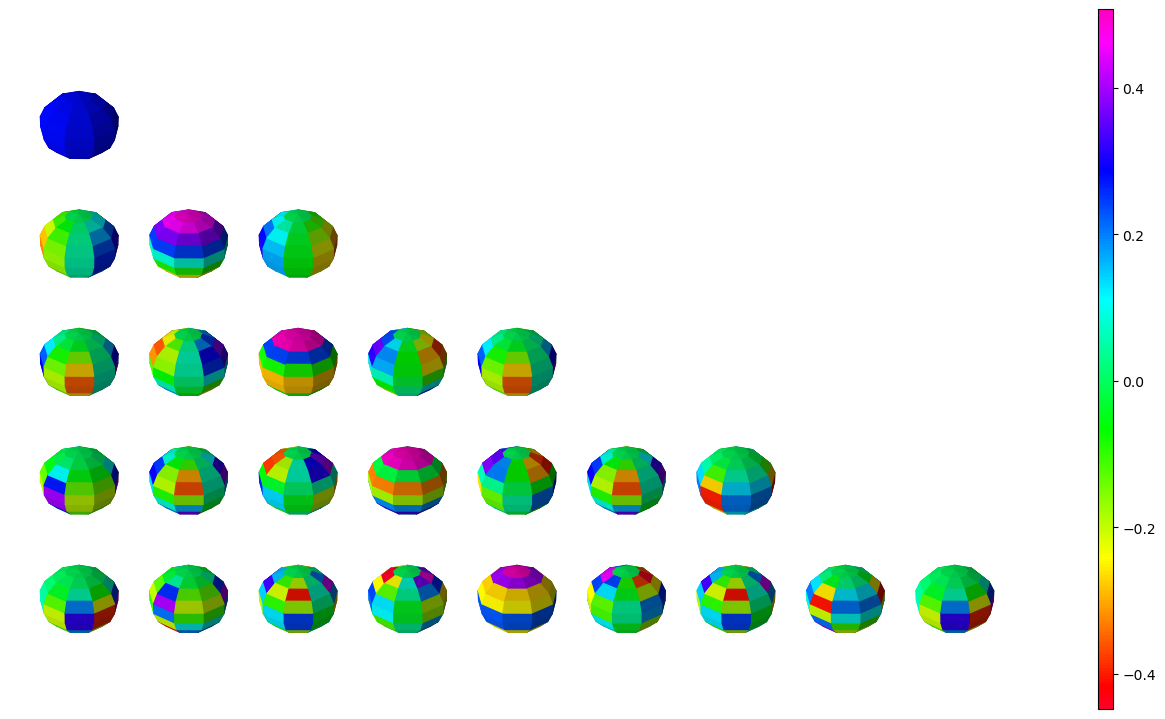

In [2]:
plotAllHarmonicsUpToDegree(4, resolution=10)

## Load dataset

In [3]:
bvals, qhat, dwis = loadhcp.load_hcp()

dwis.shape

(108, 145, 174, 145)

## Pre-processing

Remove $b=0$ measurements from the dataset.

In [4]:
bvals, qhat, dwis = remove_b_0_measurements(bvals, qhat, dwis)

Add reflections through the origin to the dataset

In [5]:
bvals, qhat, dwis = extend_dataset_with_origin_reflections(bvals, qhat, dwis)

Transform Cartesian coordinates to spherical

In [6]:
thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)

## Pick a voxel (white matter)

In [7]:
voxel = dwis[:,100,75,71]

## Plot of how the signal reconstruction error depends on the maximum SH degree

Compute the SH expansion coefficients for various values of maximum degree i.e. from $0$ to $15$ and the corresponding inverse transforms.

In [8]:
all_expansion_coefficients = []
all_inverse_spherical_fourier_transforms = []

all_design_matrices = []

# Determines the number of values used for the maximum degree
max_degree_upper_limit = 16

for max_degree in range(max_degree_upper_limit):
    design_matrix = get_design_matrix(max_degree = max_degree, number_of_samples=len(bvals), thetas=thetas, phis=phis)
    all_design_matrices.append(design_matrix)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    
    expansion_coefficients = spherical_fourier_transform @ voxel
    inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)
    
    all_expansion_coefficients.append(expansion_coefficients)
    all_inverse_spherical_fourier_transforms.append(inverse_spherical_fourier_transform)

Use the inverse transforms to reconstruct the signals.

In [9]:
all_reconstructed_signals = []

for max_degree in range(max_degree_upper_limit):
    reconstructed_signal = all_inverse_spherical_fourier_transforms[max_degree] @ all_expansion_coefficients[max_degree]
    all_reconstructed_signals.append(reconstructed_signal)

Compute the differences between the original signals and the reconstructed signals

In [10]:
all_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    reconstruction_errors = voxel - all_reconstructed_signals[max_degree]
    all_reconstruction_errors.append(reconstruction_errors)

Compute the mean reconstruction error for each value of the maximum degree

In [11]:
all_mean_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    mean_reconstruction_error = np.mean(np.absolute(all_reconstruction_errors[max_degree]))
    all_mean_reconstruction_errors.append(mean_reconstruction_error)

In [12]:
all_mean_reconstruction_errors

[264.4082836914062,
 264.4082836914062,
 126.21599779867128,
 126.21599779867128,
 108.99118454152052,
 108.99118454152052,
 102.21202133163162,
 102.21202133163162,
 85.89462804391002,
 85.89462804391002,
 59.47020192579912,
 59.47020192579912,
 4.7028455204175165e-12,
 4.7028455204175165e-12,
 2.9861742708211143e-12,
 2.9861742708211143e-12]

In [13]:
even_degree_mean_reconstruction_errors = []

for i in range(len(all_mean_reconstruction_errors)):
    if(i % 2 == 0):
        even_degree_mean_reconstruction_errors.append(all_mean_reconstruction_errors[i])

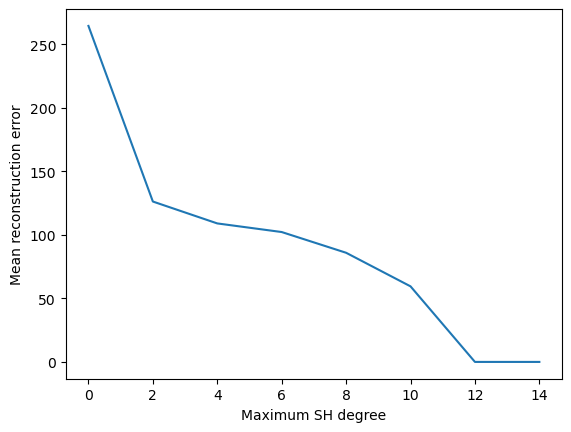

In [14]:
plt.plot(range(0,max_degree_upper_limit,2),even_degree_mean_reconstruction_errors)
plt.xticks(range(0,max_degree_upper_limit,2))
plt.xlabel("Maximum SH degree")
plt.ylabel("Mean reconstruction error")
plt.show()

## Plot the data from a single voxel and the corresponding spherical function.

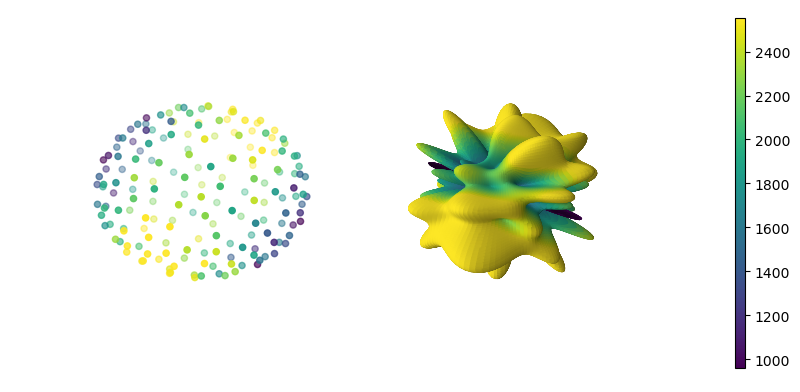

In [15]:
#%matplotlib qt
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.19, hspace=None)

ax = fig.add_subplot(121, projection="3d")
ax.scatter(qhat[0],qhat[1],qhat[2],c=voxel,vmin=1000,vmax=2000,cmap='viridis')
ax.set_axis_off()

max_value = np.max(voxel)
min_value = np.min(voxel)

cmap = plt.cm.viridis
normalization = Normalize(vmin=min_value, vmax=max_value)
sm = cm.ScalarMappable(cmap=cmap, norm=normalization)

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_expansion_coefficients[12],12,resolution=200,min_value=1000,max_value=2000)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x*fcolors, y*fcolors, z*fcolors,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), shade=True)
ax2.set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax,ax2], cax=cbar_ax)

plt.show()

## Plot of how the signal reconstruction error depends on the maximum SH degree (noise-free data)

Reconstructing noise free data can determine which maximum SH degree to use when transforming noisy data. The least maximum order that is able to reconstuct the data perfectly should be also used on noisy data to prevent overfitting.

### Load noise-free dataset

In [16]:
bvals, qhat, dwis = load_dt_simulated.load_dt_simulated_multiple_populations(number_of_data_points=90,
                                                                             b_value=1000,
                                                                             b_0_signal=3000,
                                                                             include_b_0=False,
                                                                             signal_to_noise_ratio=0,
                                                                             eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002)],
                                                                             eigenvectors=[None,None],
                                                                             fractions=[0.5,0.5],
                                                                             noise_type='none',
                                                                             noise_generator_seed=1,
                                                                             gradient_generator_seed=1)

### Pre-processing

Pre-processing is as described above.

In [17]:
bvals, qhat, dwis = extend_dataset_with_origin_reflections(bvals, qhat, dwis)

thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)

voxel = dwis

### Plotting

Plotting is done in the same way as above.

[387.1775813478273, 387.1775813478273, 134.16143535348618, 134.16143535348618, 20.480360910633653, 20.480360910633653, 4.584618778121448, 4.584618778121448, 0.42050917544765665, 0.42050917544765665, 0.026090225603527036, 0.026090225603527036, 8.498520034865781e-08, 8.498520034865781e-08, 7.37246510753822e-11, 7.37246510753822e-11]


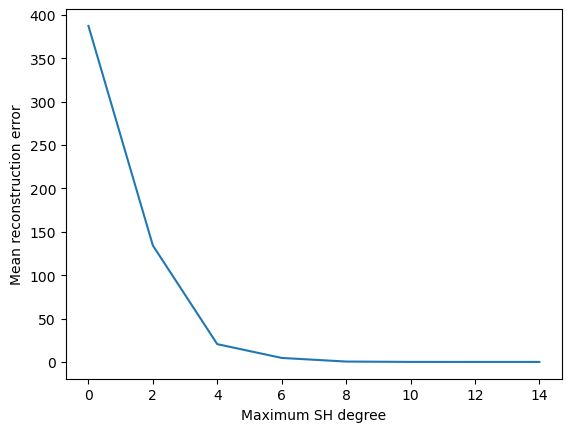

In [18]:
all_expansion_coefficients = []
all_inverse_spherical_fourier_transforms = []

all_design_matrices = []

# Determines the number of values used for the maximum degree
max_degree_upper_limit = 16

for max_degree in range(max_degree_upper_limit):
    design_matrix = get_design_matrix(max_degree = max_degree, number_of_samples=len(bvals), thetas=thetas, phis=phis)
    all_design_matrices.append(design_matrix)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    
    expansion_coefficients = spherical_fourier_transform @ voxel
    inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)
    
    all_expansion_coefficients.append(expansion_coefficients)
    all_inverse_spherical_fourier_transforms.append(inverse_spherical_fourier_transform)
    
all_reconstructed_signals = []

for max_degree in range(max_degree_upper_limit):
    reconstructed_signal = all_inverse_spherical_fourier_transforms[max_degree] @ all_expansion_coefficients[max_degree]
    all_reconstructed_signals.append(reconstructed_signal)

all_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    reconstruction_errors = voxel - all_reconstructed_signals[max_degree]
    all_reconstruction_errors.append(reconstruction_errors)

all_mean_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    mean_reconstruction_error = np.mean(np.absolute(all_reconstruction_errors[max_degree]))
    all_mean_reconstruction_errors.append(mean_reconstruction_error)

print(all_mean_reconstruction_errors)

even_degree_mean_reconstruction_errors = []

for i in range(len(all_mean_reconstruction_errors)):
    if(i % 2 == 0):
        even_degree_mean_reconstruction_errors.append(all_mean_reconstruction_errors[i])

plt.plot(range(0,max_degree_upper_limit,2),even_degree_mean_reconstruction_errors)
plt.xticks(range(0,max_degree_upper_limit,2))
plt.xlabel("Maximum SH degree")
plt.ylabel("Mean reconstruction error")
plt.show()

In [19]:
print(all_mean_reconstruction_errors)

[387.1775813478273, 387.1775813478273, 134.16143535348618, 134.16143535348618, 20.480360910633653, 20.480360910633653, 4.584618778121448, 4.584618778121448, 0.42050917544765665, 0.42050917544765665, 0.026090225603527036, 0.026090225603527036, 8.498520034865781e-08, 8.498520034865781e-08, 7.37246510753822e-11, 7.37246510753822e-11]


## Reconstruction error of noisy (SNR = 30) DW signals as compared to noise free signals (1 fibre population) with varying maximum spherical harmonics degree

### Load noisy dataset

In [20]:
bvals_noisy, qhat_noisy, dwis_noisy = load_dt_simulated.load_dt_simulated(number_of_data_points=90,
                                                                          b_value=1000,
                                                                          b_0_signal=3000,
                                                                          include_b_0=False,
                                                                          signal_to_noise_ratio=30,
                                                                          eigenvalues=(0.003, 0.0002, 0.0002),
                                                                          eigenvectors=None,
                                                                          noise_type='rician',
                                                                          noise_generator=np.random.default_rng(1),
                                                                          gradient_generator=np.random.default_rng(1))

### Load noise-free dataset

In [21]:
bvals_noise_free, qhat_noise_free, dwis_noise_free = load_dt_simulated.load_dt_simulated(number_of_data_points=90,
                                                                                         b_value=1000,
                                                                                         b_0_signal=3000,
                                                                                         include_b_0=False,
                                                                                         signal_to_noise_ratio=0,
                                                                                         eigenvalues=(0.003, 0.0002, 0.0002),
                                                                                         eigenvectors=None,
                                                                                         noise_type='none',
                                                                                         noise_generator=np.random.default_rng(1),
                                                                                         gradient_generator=np.random.default_rng(1))

### Pre-processing

In [22]:
bvals_noisy, qhat_noisy, dwis_noisy = extend_dataset_with_origin_reflections(bvals_noisy, qhat_noisy, dwis_noisy)
thetas_noisy, phis_noisy = convert_coords_from_cartesian_to_spherical(qhat_noisy)
voxel_noisy = dwis_noisy

bvals_noise_free, qhat_noise_free, dwis_noise_free = extend_dataset_with_origin_reflections(bvals_noise_free, qhat_noise_free, dwis_noise_free)
thetas_noise_free, phis_noise_free = convert_coords_from_cartesian_to_spherical(qhat_noise_free)
voxel_noise_free = dwis_noise_free

### Plot the reconstruction error of noisy data when compared to noise free data

[723.1204827994719, 723.1204827994719, 211.89740257963098, 211.89740257963098, 38.81250758978425, 38.81250758978425, 5.769278577583724, 5.769278577583724, 0.7490745453657095, 0.7490745453657095, 0.03741195670205618, 0.03741195670205618, 0.024238819147101274, 0.024238819147101274, 0.024238809219886547, 0.024238809219886547]


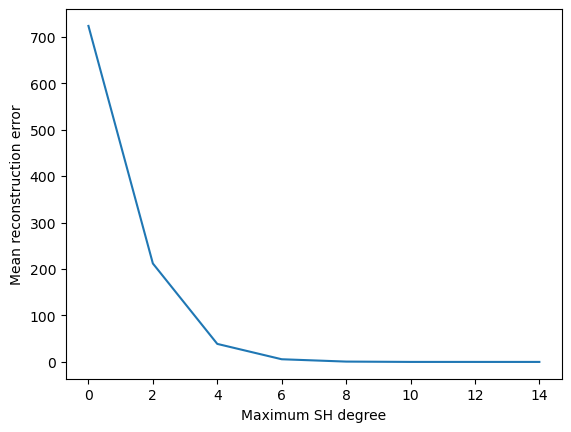

In [23]:
plot_reconstruction_error_using_spherical_harmonics_up_to_degree(measurements=voxel_noisy, thetas=thetas_noisy, phis=phis_noisy, max_degree_upper_limit=16, comparison_measurements=voxel_noise_free)

## Reconstruction error of noisy DW signals as compared to noise free signals (2 fibre populations) with varying maximum spherical harmonics degree

### Load noisy dataset

In [24]:
bvals_noisy, qhat_noisy, dwis_noisy = load_dt_simulated.load_dt_simulated_multiple_populations(number_of_data_points=90,
                                                                                               b_value=1000,
                                                                                               b_0_signal=3000,
                                                                                               include_b_0=False,
                                                                                               signal_to_noise_ratio=30,
                                                                                               eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002)],
                                                                                               eigenvectors=[None,None],
                                                                                               fractions=[0.5,0.5],
                                                                                               noise_type='rician',
                                                                                               noise_generator_seed=1,
                                                                                               gradient_generator_seed=1)

### Load noise-free dataset

In [25]:
bvals_noise_free, qhat_noise_free, dwis_noise_free = load_dt_simulated.load_dt_simulated_multiple_populations(number_of_data_points=90,
                                                                                                              b_value=1000,
                                                                                                              b_0_signal=3000,
                                                                                                              include_b_0=False,
                                                                                                              signal_to_noise_ratio=0,
                                                                                                              eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002)],
                                                                                                              eigenvectors=[None,None],
                                                                                                              fractions=[0.5,0.5],
                                                                                                              noise_type='none',
                                                                                                              noise_generator_seed=1,
                                                                                                              gradient_generator_seed=1)

### Pre-processing

In [26]:
bvals_noisy, qhat_noisy, dwis_noisy = extend_dataset_with_origin_reflections(bvals_noisy, qhat_noisy, dwis_noisy)
thetas_noisy, phis_noisy = convert_coords_from_cartesian_to_spherical(qhat_noisy)
voxel_noisy = dwis_noisy

bvals_noise_free, qhat_noise_free, dwis_noise_free = extend_dataset_with_origin_reflections(bvals_noise_free, qhat_noise_free, dwis_noise_free)
thetas_noise_free, phis_noise_free = convert_coords_from_cartesian_to_spherical(qhat_noise_free)
voxel_noise_free = dwis_noise_free

### Plot the reconstruction error of noisy data when compared to noise free data

[387.17700969617147, 387.17700969617147, 134.1617205103546, 134.1617205103546, 20.481480935927177, 20.481480935927177, 4.5833834914505065, 4.5833834914505065, 0.42174253498968206, 0.42174253498968206, 0.034743204063550415, 0.034743204063550415, 0.02423860452414538, 0.02423860452414538, 0.02423859649690535, 0.02423859649690535]


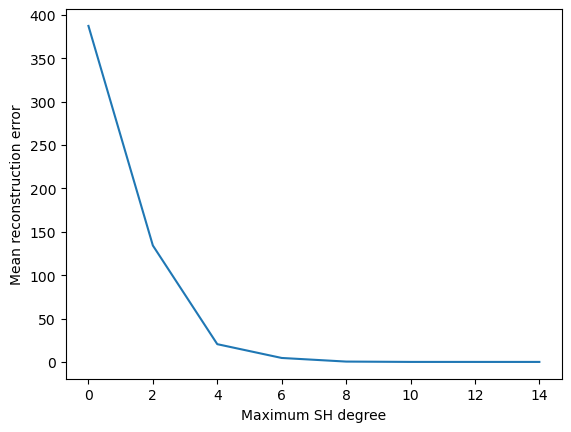

In [27]:
plot_reconstruction_error_using_spherical_harmonics_up_to_degree(measurements=voxel_noisy, thetas=thetas_noisy, phis=phis_noisy, max_degree_upper_limit=16, comparison_measurements=voxel_noise_free)

## Reconstruction error of noisy DW signals as compared to noise free signals (3 fibre populations) with varying maximum spherical harmonics degree

### Load noisy dataset

In [28]:
bvals_noisy, qhat_noisy, dwis_noisy = load_dt_simulated.load_dt_simulated_multiple_populations(number_of_data_points=90,
                                                                                               b_value=1000,
                                                                                               b_0_signal=3000,
                                                                                               include_b_0=False,
                                                                                               signal_to_noise_ratio=30,
                                                                                               eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002),(0.0002, 0.0002, 0.003)],
                                                                                               eigenvectors=[None,None,None],
                                                                                               fractions=[0.333,0.333,0.333],
                                                                                               noise_type='rician',
                                                                                               noise_generator_seed=23,
                                                                                               gradient_generator_seed=24)

### Load noise-free dataset

In [29]:
bvals_noise_free, qhat_noise_free, dwis_noise_free = load_dt_simulated.load_dt_simulated_multiple_populations(number_of_data_points=90,
                                                                                                              b_value=1000,
                                                                                                              b_0_signal=3000,
                                                                                                              include_b_0=False,
                                                                                                              signal_to_noise_ratio=0,
                                                                                                              eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002),(0.0002, 0.0002, 0.003)],
                                                                                                              eigenvectors=[None,None,None],
                                                                                                              fractions=[0.333,0.333,0.333],
                                                                                                              noise_type='none',
                                                                                                              noise_generator_seed=23,
                                                                                                              gradient_generator_seed=24)

### Pre-processing

In [30]:
bvals_noisy, qhat_noisy, dwis_noisy = extend_dataset_with_origin_reflections(bvals_noisy, qhat_noisy, dwis_noisy)
thetas_noisy, phis_noisy = convert_coords_from_cartesian_to_spherical(qhat_noisy)
voxel_noisy = dwis_noisy

bvals_noise_free, qhat_noise_free, dwis_noise_free = extend_dataset_with_origin_reflections(bvals_noise_free, qhat_noise_free, dwis_noise_free)
thetas_noise_free, phis_noise_free = convert_coords_from_cartesian_to_spherical(qhat_noise_free)
voxel_noise_free = dwis_noise_free

### Plot the reconstruction error of noisy data when compared to noise free data

[145.22471631868243, 145.22471631868243, 143.325638889126, 143.325638889126, 14.069714298817926, 14.069714298817926, 4.34119108715097, 4.34119108715097, 0.2546733533698696, 0.2546733533698696, 0.04027245972482408, 0.04027245972482408, 0.02857435930726145, 0.02857435930726145, 0.028574346460698685, 0.028574346460698685]


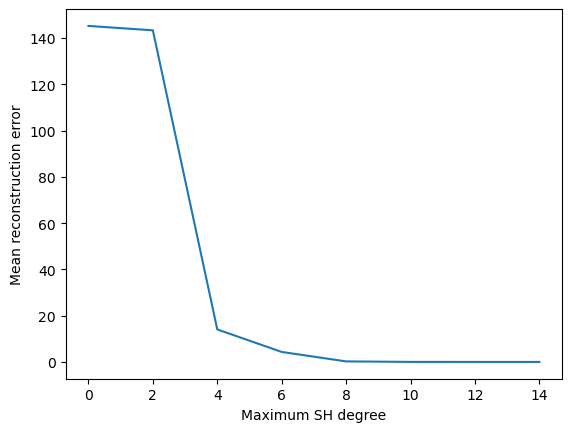

In [31]:
plot_reconstruction_error_using_spherical_harmonics_up_to_degree(measurements=voxel_noisy, thetas=thetas_noisy, phis=phis_noisy, max_degree_upper_limit=16, comparison_measurements=voxel_noise_free)